# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# might have to pip install -q transformers
from transformers import pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
import random
from sklearn.linear_model import LinearRegression
import re

# Import Data

In [2]:
data = pd.read_csv('Recipe Reviews and User Feedback Dataset.csv')

# General Data Summary

In [33]:
n_reviews = data.shape[0]
n_columns = data.shape[1]
n_recipes = data["recipe_number"].nunique()
print("Number of Features: ", n_columns)
print("Number of Reviews: ", n_reviews)
print("Number of Recipes: ", n_recipes)

Number of Reviews:  18182
Number of Recipes:  100
Number of Features:  15


In [3]:
total_thumbs = data.groupby('recipe_code').agg({'thumbs_up': 'sum', 'thumbs_down': 'sum', 'recipe_code': 'count'})
total_thumbs.columns = ['total_thumbs_up', 'total_thumbs_down', 'count']

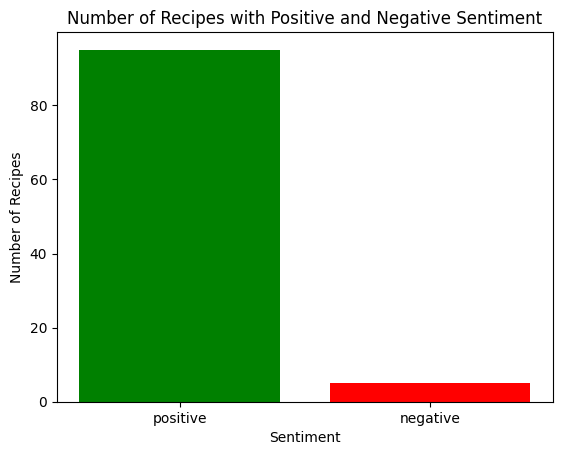

In [4]:
total_thumbs['sentiment'] = 'positive'
total_thumbs.loc[total_thumbs['total_thumbs_up'] < total_thumbs['total_thumbs_down'], 'sentiment'] = 'negative'

# Count the number of recipes with positive and negative sentiment
sentiment_counts = total_thumbs['sentiment'].value_counts()

# Plotting
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Recipes')
plt.title('Number of Recipes with Positive and Negative Sentiment')
plt.show()


# Part 1: Sentiment Analysis of Reviews

In [5]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [6]:
x = sentiment_pipeline(data['text'][0])

In [7]:
x

[{'label': 'POSITIVE', 'score': 0.9997697472572327}]

In [8]:
x[0]['score']

0.9997697472572327

In [9]:
sentiment_df = data
sentiment_df["sentiment_score"] = None

In [10]:
def remove_html_entity(input_string):
    input_string = str(input_string)
    result_string = input_string.replace("&#39;", "")
    result_string = result_string.replace("<h1>", "")
    result_string = result_string.replace("</h1>", "")
    result_string = result_string.replace("<span>", "")
    result_string = result_string.replace("</span>", "")
    result_string = result_string.replace("<li>", "")
    result_string = result_string.replace("</li>", "")
    result_string = result_string.replace("<i>", "")
    result_string = result_string.replace("</i>", "")
    result_string = result_string.replace("<h2>", "")
    result_string = result_string.replace("</h2>", "")
    result_string = result_string.replace("<ul>", "")
    result_string = result_string.replace("</ul>", "")
    result_string = result_string.replace("<b>", "")
    result_string = result_string.replace("</b>", "")
    result_string = result_string.replace("\xa0", "")
    

    return result_string

In [ ]:
# Change the object to a list
texts = []
for t in range(len(sentiment_df['text'])):
    text = sentiment_df['text'][t]
    text = remove_html_entity(text)
    if str(text) != "nan":
        texts.append(text)
        if len(text) > 2000:
            text_1 = text[0:1500]
            text_2 = text[1500:]
            sentiment_1 = sentiment_pipeline(text_1)[0]['score']
            sentiment_2 = sentiment_pipeline(text_2)[0]['score']
            sentiment_df["sentiment_score"][t] = (sentiment_1  + sentiment_2)/2
        else:
            sentiment_df["sentiment_score"][t] = sentiment_pipeline(text)[0]['score']
    else:
        sentiment_df["sentiment_score"][t] = 0

/var/folders/3k/0s83074d3_93z_bq3nvj2n0r0000gn/T/ipykernel_1470/2769961053.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df["sentiment_score"][t] = sentiment_pipeline(text)[0]['score']
/var/folders/3k/0s83074d3_93z_bq3nvj2n0r0000gn/T/ipykernel_1470/2769961053.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df["sentiment_score"][t] = 0
/var/folders/3k/0s83074d3_93z_bq3nvj2n0r0000gn/T/ipykernel_1470/2769961053.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
sentiment_df.to_csv('sentiment_df.csv', index=False)

# Question 1
Do reviews with more positive scores recieve more thumbs up? Same with vice versa

In [42]:
sen_data = pd.read_csv('sentiment_df.csv')

In [19]:
# Linear Regression
X = sen_data['sentiment_score'].values.reshape(-1, 1)
y = sen_data['thumbs_up'].values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

predictions = model.predict(X)

In [22]:
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

intercept: 2.5378081319785952
slope: [-1.47884312]


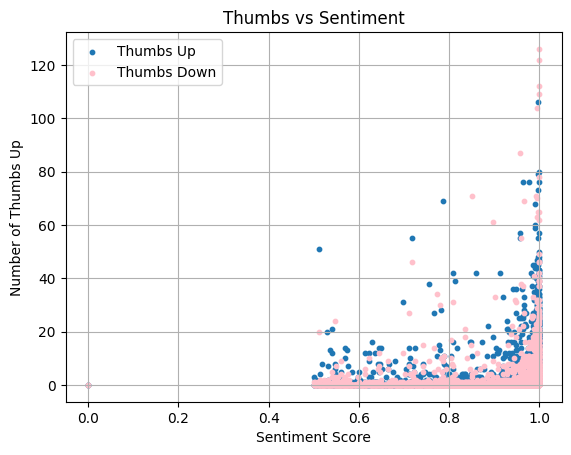

In [123]:
plt.figure()
plt.scatter(sen_data['sentiment_score'], sen_data['thumbs_up'], label = "Thumbs Up", s = 10) 
plt.scatter(sen_data['sentiment_score'], sen_data['thumbs_down'], color = "pink", label = "Thumbs Down", s = 10) 
#plt.plot(X, predictions, color='red', label = "Linear Regression")
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Thumbs Up')
plt.title('Thumbs vs Sentiment')
plt.legend()
plt.grid()
plt.legend()
plt.show()

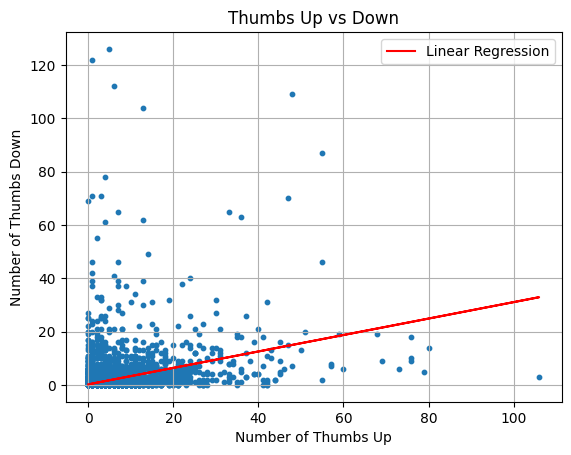

In [125]:
# Linear Regression
X = sen_data['thumbs_up'].values.reshape(-1, 1)
y = sen_data['thumbs_down'].values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

predictions = model.predict(X)

plt.figure()
plt.scatter(sen_data['thumbs_up'], sen_data['thumbs_down'],  s = 10) 
plt.plot(X, predictions, color='red', label = "Linear Regression")
plt.xlabel('Number of Thumbs Up')
plt.ylabel('Number of Thumbs Down')
plt.title('Thumbs Up vs Down')
#plt.legend()
plt.grid()
plt.legend()
plt.show()

Remove the outliers of 0s from th thumbs up category

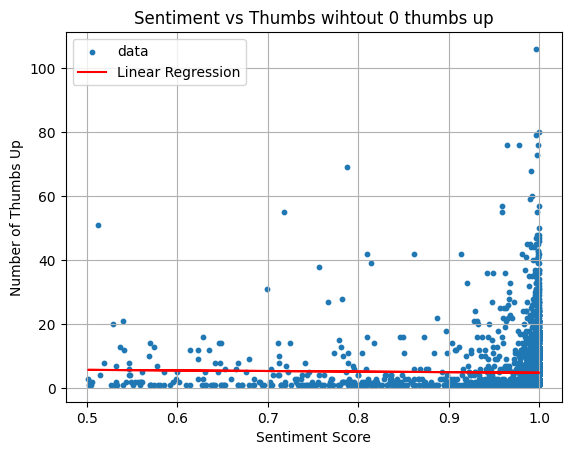

In [69]:
remove_outlier =  sen_data[sen_data['thumbs_up'] != 0]

# Linear Regression
X_2 = remove_outlier['sentiment_score'].values.reshape(-1, 1)
y_2 = remove_outlier['thumbs_up'].values

# Fit linear regression model
model_2 = LinearRegression()
model_2.fit(X_2, y_2)

predictions_2 = model_2.predict(X_2)

plt.figure()
plt.scatter(remove_outlier['sentiment_score'], remove_outlier['thumbs_up'], label = "data", s = 10) 
plt.plot(X_2, predictions_2, color='red', label = "Linear Regression")
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Thumbs Up')
plt.title('Sentiment vs Thumbs wihtout 0 thumbs up')
plt.legend()
plt.grid()
plt.legend()
plt.show()

WHAT TREND IS THERE

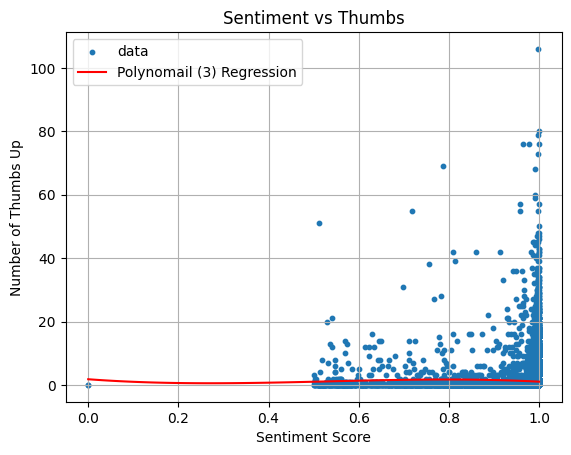

In [86]:
mymodel = np.poly1d(np.polyfit(sen_data['sentiment_score'], sen_data['thumbs_up'], 3))

myline = np.linspace(0, 1, 100)

plt.figure()
plt.scatter(sen_data['sentiment_score'], sen_data['thumbs_up'], label = "data", s = 10) 
plt.plot(myline, mymodel(myline), color='red', label = "Polynomail (3) Regression")
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Thumbs Up')
plt.title('Sentiment vs Thumbs')
plt.legend()
plt.grid()
plt.legend()
plt.show()

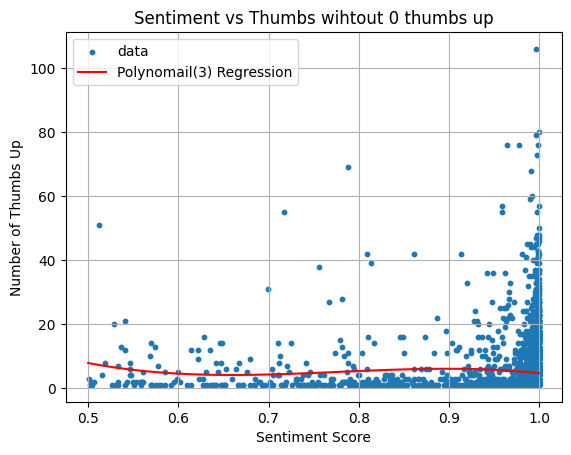

In [88]:
mymodel = np.poly1d(np.polyfit(remove_outlier['sentiment_score'], remove_outlier['thumbs_up'], 3))

myline = np.linspace(0.5, 1, 100)

plt.figure()
plt.scatter(remove_outlier['sentiment_score'], remove_outlier['thumbs_up'], label = "data", s = 10) 
plt.plot(myline, mymodel(myline), color='red', label = "Polynomail(3) Regression")
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Thumbs Up')
plt.title('Sentiment vs Thumbs wihtout 0 thumbs up')
plt.legend()
plt.grid()
plt.legend()
plt.show()

Okay none of those are helpful, lets instead do some buckets!

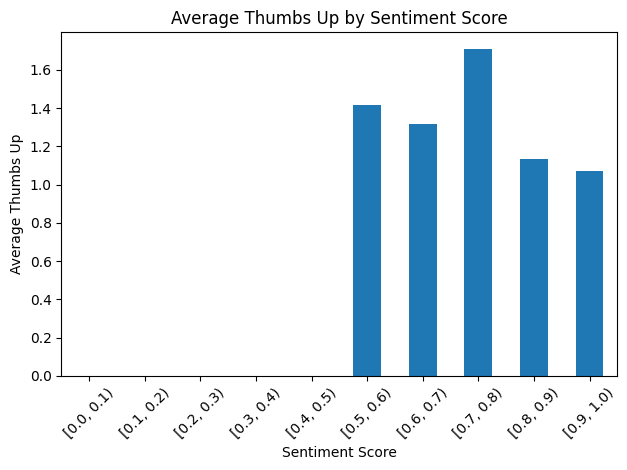

In [28]:
# Define the bins for sentiment scores
bins = [i/10 for i in range(11)]  # Bins of size 0.1 from 0 to 1

# Add a new column with the bin each sentiment score belongs to
sen_data['sentiment_bin'] = pd.cut(sen_data['sentiment_score'], bins=bins, right=False)

# Group by the sentiment bin and calculate the average thumbs up
grouped = sen_data.groupby('sentiment_bin')['thumbs_up'].mean()

# Plot the bar plot
grouped.plot(kind='bar')

# Customize the plot
plt.xlabel('Sentiment Score')
plt.ylabel('Average Thumbs Up')
plt.title('Average Thumbs Up by Sentiment Score')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

/var/folders/pz/lc5f5cgd1m5_ghmjddlz8r600000gn/T/ipykernel_41360/1897672215.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_outlier['sentiment_bin'] = pd.cut(remove_outlier['sentiment_score'], bins=bins, right=False)


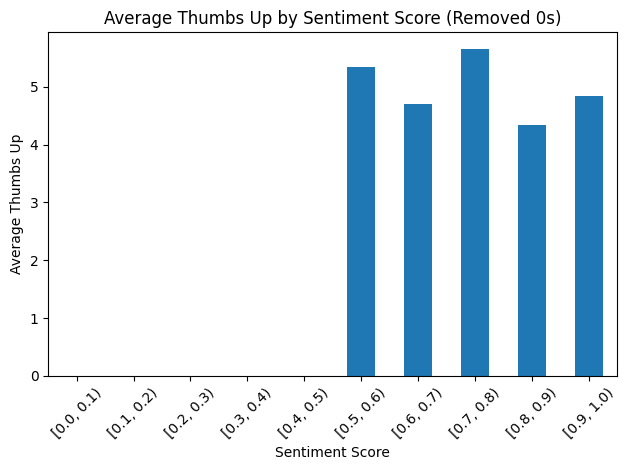

In [29]:
# Define the bins for sentiment scores
bins = [i/10 for i in range(11)]  # Bins of size 0.1 from 0 to 1

# Add a new column with the bin each sentiment score belongs to
remove_outlier['sentiment_bin'] = pd.cut(remove_outlier['sentiment_score'], bins=bins, right=False)

# Group by the sentiment bin and calculate the average thumbs up
grouped = remove_outlier.groupby('sentiment_bin')['thumbs_up'].mean()

# Plot the bar plot
grouped.plot(kind='bar')

# Customize the plot
plt.xlabel('Sentiment Score')
plt.ylabel('Average Thumbs Up')
plt.title('Average Thumbs Up by Sentiment Score (Removed 0s)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

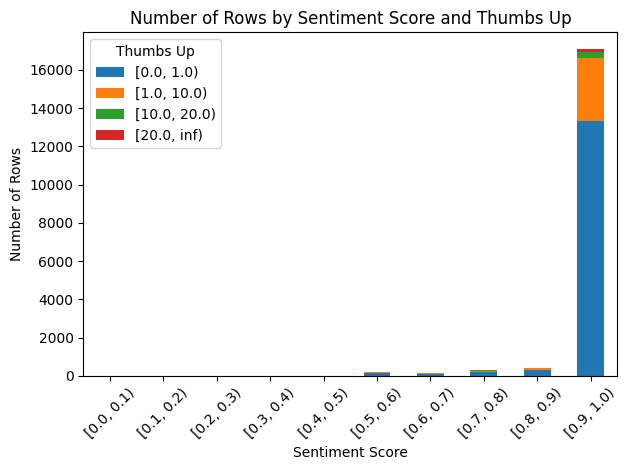

In [89]:
# Define the bins for sentiment scores
bins = [i/10 for i in range(11)]  # Bins of size 0.1 from 0 to 1

# Add a new column with the bin each sentiment score belongs to
sen_data['sentiment_bin'] = pd.cut(sen_data['sentiment_score'], bins=bins, right=False)

# Define custom bins for the number of thumbs up
thumbs_up_bins = [0, 1, 10, 20, float('inf')]  # Bins for 0-10, 10-50, 50+

# Add a new column with the bin each thumbs up count belongs to
sen_data['thumbs_up_bin'] = pd.cut(sen_data['thumbs_up'], bins=thumbs_up_bins, right=False)

# Count the number of rows falling into each bin
grouped = sen_data.groupby(['sentiment_bin', 'thumbs_up_bin']).size().unstack(fill_value=0)

# Plot the bar plot
grouped.plot(kind='bar', stacked=True)

# Customize the plot
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Rows')
plt.title('Number of Rows by Sentiment Score and Thumbs Up')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.legend(title='Thumbs Up')
plt.show()

/var/folders/pz/lc5f5cgd1m5_ghmjddlz8r600000gn/T/ipykernel_41360/3357227535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_outlier['sentiment_bin'] = pd.cut(remove_outlier['sentiment_score'], bins=bins, right=False)
/var/folders/pz/lc5f5cgd1m5_ghmjddlz8r600000gn/T/ipykernel_41360/3357227535.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_outlier['thumbs_up_bin'] = pd.cut(remove_outlier['thumbs_up'], bins=thumbs_up_bins, right=False)


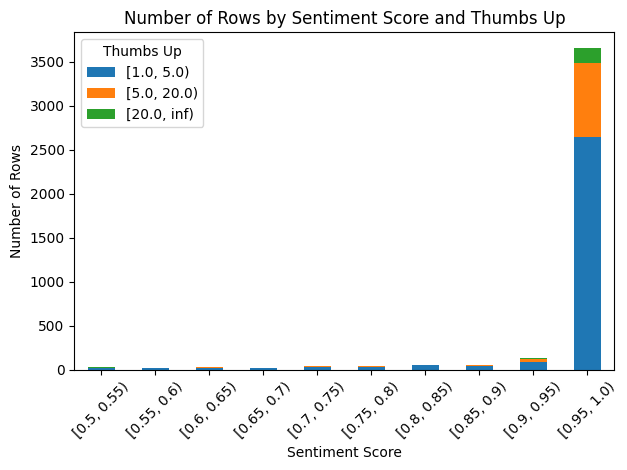

In [100]:
# Define the bins for sentiment scores
bins = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]  # Bins of size 0.1 from 0 to 1

# Add a new column with the bin each sentiment score belongs to
remove_outlier['sentiment_bin'] = pd.cut(remove_outlier['sentiment_score'], bins=bins, right=False)

# Define custom bins for the number of thumbs up
thumbs_up_bins = [1, 5, 20, float('inf')]  # Bins for 0-10, 10-50, 50+

# Add a new column with the bin each thumbs up count belongs to
remove_outlier['thumbs_up_bin'] = pd.cut(remove_outlier['thumbs_up'], bins=thumbs_up_bins, right=False)

# Count the number of rows falling into each bin
grouped = remove_outlier.groupby(['sentiment_bin', 'thumbs_up_bin']).size().unstack(fill_value=0)

# Plot the bar plot
grouped.plot(kind='bar', stacked=True)

# Customize the plot
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Rows')
plt.title('Number of Rows by Sentiment Score and Thumbs Up')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.legend(title='Thumbs Up')
plt.show()

/var/folders/pz/lc5f5cgd1m5_ghmjddlz8r600000gn/T/ipykernel_41360/2438668735.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_outlier['thumbs_up_bin'] = pd.cut(remove_outlier['thumbs_up'], bins=thumbs_up_bins, right=False)


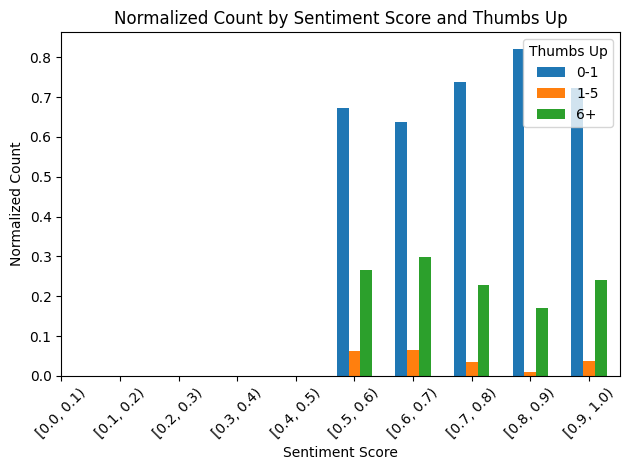

In [99]:
# Define custom bins for the number of thumbs up
thumbs_up_bins = [1, 5, 6, float('inf')]  # Bins for 0-10, 10-50, 50+

# Add a new column with the bin each thumbs up count belongs to
remove_outlier['thumbs_up_bin'] = pd.cut(remove_outlier['thumbs_up'], bins=thumbs_up_bins, right=False)

# Count the number of rows falling into each bin
grouped = remove_outlier.groupby(['sentiment_bin', 'thumbs_up_bin']).size().unstack(fill_value=0)

# Normalize the counts by the number of rows in each sentiment score bin
grouped_normalized = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the bar plot
width = 0.2  # Width of each bar
x = np.arange(len(grouped_normalized.index))  # the label locations

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, grouped_normalized.iloc[:, 0], width, label='0-1')
rects2 = ax.bar(x, grouped_normalized.iloc[:, 1], width, label='1-5')
rects3 = ax.bar(x + width, grouped_normalized.iloc[:, 2], width, label='6+')

# Customize the plot
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Normalized Count')
ax.set_title('Normalized Count by Sentiment Score and Thumbs Up')
ax.set_xticks(x)
ax.set_xticklabels(grouped_normalized.index)
ax.legend(title='Thumbs Up')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

/var/folders/pz/lc5f5cgd1m5_ghmjddlz8r600000gn/T/ipykernel_41360/745480591.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_outlier['sentiment_bin'] = pd.cut(remove_outlier['sentiment_score'], bins=bins, right=False)
/var/folders/pz/lc5f5cgd1m5_ghmjddlz8r600000gn/T/ipykernel_41360/745480591.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_outlier['thumbs_down_bin'] = pd.cut(remove_outlier['thumbs_down'], bins=thumbs_up_bins, right=False)


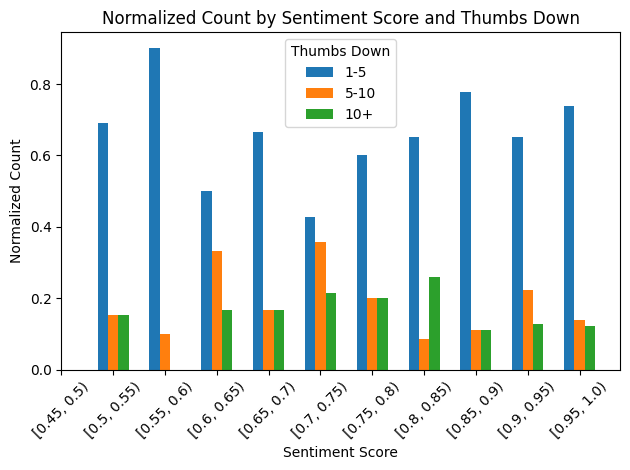

In [120]:
# Define custom bins for the number of thumbs up
bins = [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,0.9, 0.95,1] 

# Add a new column with the bin each sentiment score belongs to
remove_outlier['sentiment_bin'] = pd.cut(remove_outlier['sentiment_score'], bins=bins, right=False)

thumbs_up_bins = [1, 5, 10, float('inf')]  

# Add a new column with the bin each thumbs up count belongs to
remove_outlier['thumbs_down_bin'] = pd.cut(remove_outlier['thumbs_down'], bins=thumbs_up_bins, right=False)

# Count the number of rows falling into each bin
grouped = remove_outlier.groupby(['sentiment_bin', 'thumbs_down_bin']).size().unstack(fill_value=0)

# Normalize the counts by the number of rows in each sentiment score bin
grouped_normalized = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the bar plot
width = 0.2  # Width of each bar
x = np.arange(len(grouped_normalized.index))  # the label locations

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, grouped_normalized.iloc[:, 0], width, label='1-5')
rects2 = ax.bar(x, grouped_normalized.iloc[:, 1], width, label='5-10')
rects3 = ax.bar(x + width, grouped_normalized.iloc[:, 2], width, label='10+')

# Customize the plot
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Normalized Count')
ax.set_title('Normalized Count by Sentiment Score and Thumbs Down')
ax.set_xticks(x)
ax.set_xticklabels(grouped_normalized.index)
ax.legend(title='Thumbs Down')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

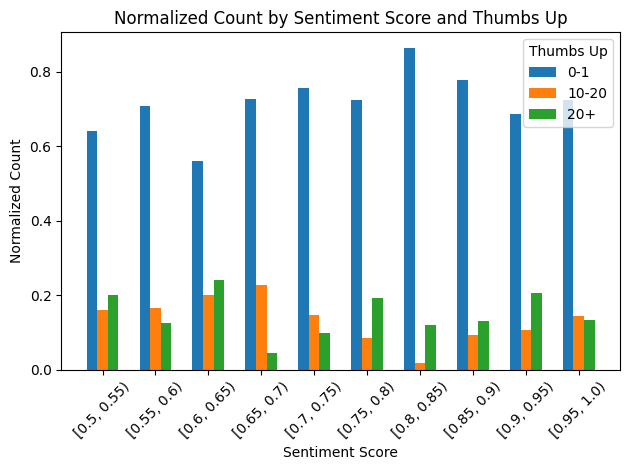

In [112]:
# Define custom bins for the number of thumbs up
bins = [i/10 for i in range(11)]  # Bins of size 0.1 from 0 to 1

# Add a new column with the bin each thumbs up count belongs to
sen_data['thumbs_up_bin'] = pd.cut(sen_data['thumbs_up'], bins=thumbs_up_bins, right=False)

# Count the number of rows falling into each bin
grouped = sen_data.groupby(['sentiment_bin', 'thumbs_up_bin']).size().unstack(fill_value=0)

# Normalize the counts by the number of rows in each sentiment score bin
grouped_normalized = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the bar plot
width = 0.2  # Width of each bar
x = np.arange(len(grouped_normalized.index))  # the label locations

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, grouped_normalized.iloc[:, 0], width, label='0-1')
rects2 = ax.bar(x, grouped_normalized.iloc[:, 1], width, label='10-20')
rects3 = ax.bar(x + width, grouped_normalized.iloc[:, 2], width, label='20+')

# Customize the plot
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Normalized Count')
ax.set_title('Normalized Count by Sentiment Score and Thumbs Up')
ax.set_xticks(x)
ax.set_xticklabels(grouped_normalized.index)
ax.legend(title='Thumbs Up')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Question 2 - Reviews Overtime
### How do the reviews change overtime if at all? 
- Use timestamps to make “timeline” of review sentiments overtime
- Use the running average of the ratings to look for deviations from average. 

## Step 1: One recipe
Get all review for one recipie and track sentiments & thumbs up over time

In [60]:
random_idx = random.randint(1, len(data))
recipie_code = data['recipe_code'][random_idx]

In [61]:
recipie_reviews = data[data['recipe_code'] == recipie_code]
# sort by time
recipie_reviews = recipie_reviews.sort_values(by='created_at')

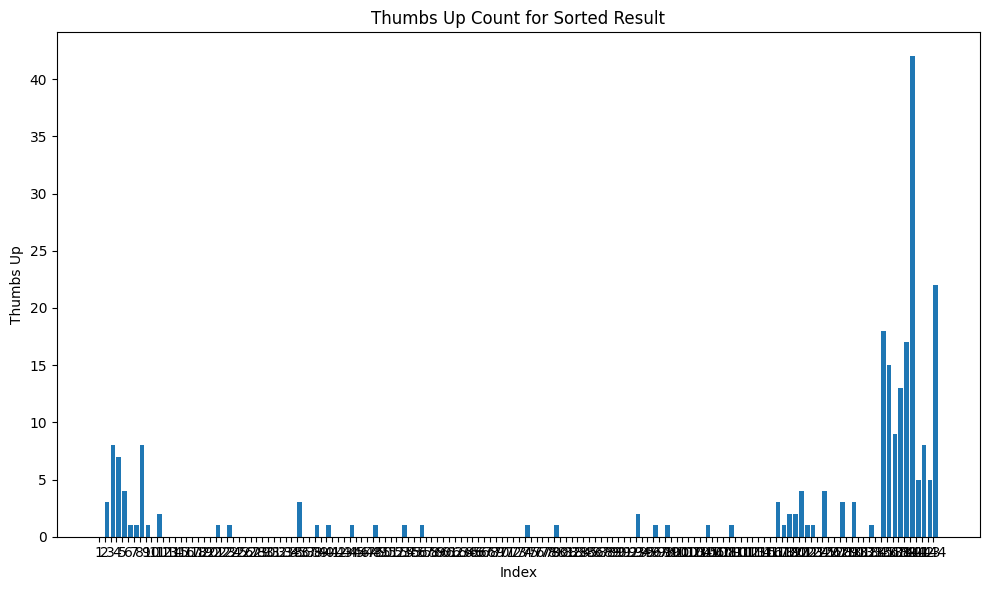

In [62]:
# Plotting the bar plot
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.bar(range(len(recipie_reviews)), recipie_reviews['thumbs_up'], align='edge')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Thumbs Up')
plt.title('Thumbs Up Count for Sorted Result')
plt.xticks(range(len(recipie_reviews)), range(1, len(recipie_reviews) + 1))

# Show plot
plt.tight_layout()
plt.show()

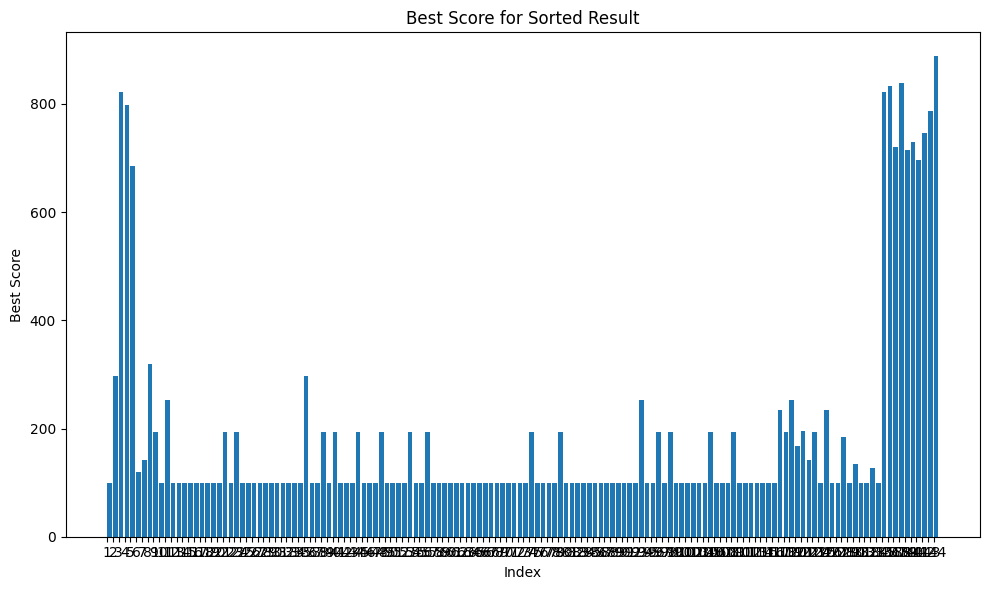

In [64]:
# Plotting the bar plot
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.bar(range(len(recipie_reviews)), recipie_reviews['best_score'], align='edge')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Best Score')
plt.title('Best Score for Sorted Result')
plt.xticks(range(len(recipie_reviews)), range(1, len(recipie_reviews) + 1))

# Show plot
plt.tight_layout()
plt.show()

### Sentiment

In [54]:
random_idx = random.randint(1, len(sen_data))
recipie_code = sen_data['recipe_code'][random_idx]
recipie_reviews = sen_data[sen_data['recipe_code'] == recipie_code]
recipie_reviews = recipie_reviews.sort_values(by='created_at')

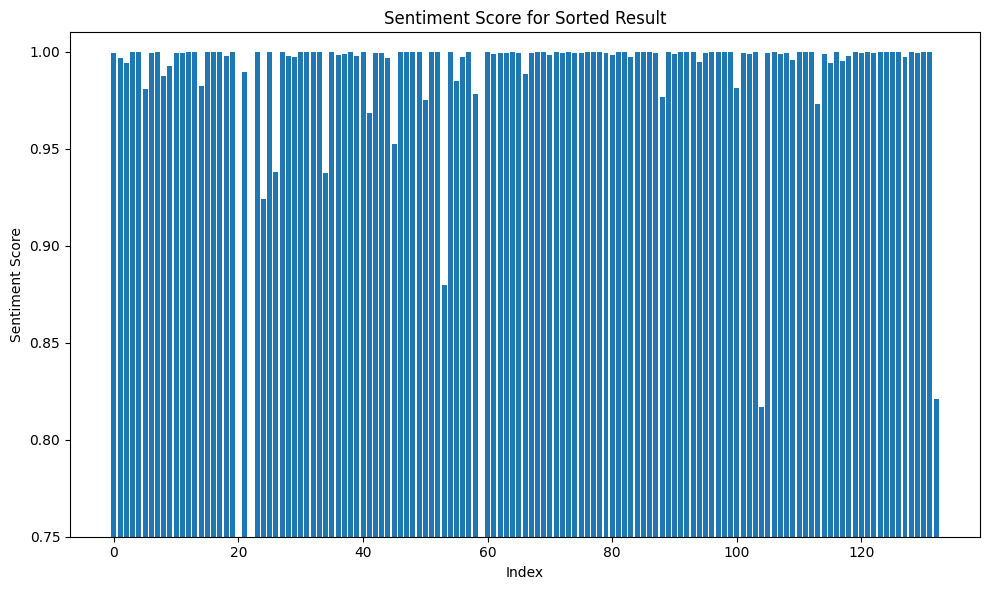

In [55]:
# Plotting the bar plot
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.bar(range(len(recipie_reviews)), recipie_reviews['sentiment_score'])

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score for Sorted Result')
plt.ylim(0.75, 1.01)
#plt.xticks(range(len(recipie_reviews)), range(1, len(recipie_reviews) + 1))

# Show plot
plt.tight_layout()
plt.show()

looks like sentiments DO NOT change overtime but "best score" does! There are definitley some deviations though which is pretty interesting!

# Question 3 - Length of Reviews vs. Intearctions
### Does the length of the review indicate anything about it's sentiment?
- Calculate average length of reviews for each recipe.
- Calculate average total interactions for reviews of each recipe. 
- Calculate average reply count for reviews of each recipe.
- Calculate average thumbs up for reviews of each recipe.
- Calculate average thumbs down for reviews of each recipe. 

## 1) Calculate average length, total interactions, replies, thumbs up & thumbs down of reviews for each recipe

In [7]:
avg_length = data.groupby('recipe_code').apply(lambda x: pd.Series({
                    'avg_length': x['text'].str.len().mean(),
                    'avg_created_at': x['created_at'].mean(),
                    'num_reviews': x.shape[0],
                    'avg_replies': x['reply_count'].mean(),
                    'avg_thumbs_up': x['thumbs_up'].mean(),
                    'avg_thumbs_down': x['thumbs_down'].mean(),
                    'avg_score': x['best_score'].mean(),
                    'avg_total_interactions': x['reply_count'].mean() + x['thumbs_up'].mean() + x['thumbs_down'].mean()
                    })).reset_index()
avg_length.tail()

,recipe_code,avg_length,avg_created_at,num_reviews,avg_replies,avg_thumbs_up,avg_thumbs_down,avg_score,avg_total_interactions
95,74724,191.204082,1.623096e+09,147.0,0.000000,0.163265,0.061224,118.734694,0.224490
96,82745,252.899160,1.625245e+09,119.0,0.033613,1.554622,0.789916,208.865546,2.378151
97,100276,157.195122,1.623248e+09,164.0,0.012195,1.365854,0.457317,161.817073,1.835366
98,141947,241.719298,1.624951e+09,114.0,0.008772,3.114035,1.692982,219.684211,4.815789
99,191775,243.008929,1.624278e+09,112.0,0.000000,1.258929,0.535714,188.821429,1.794643


## 2) Perform Linear Regression on the number of reviews, average replies, average thumbs up & thumbs down with average review length as the target.

In [8]:
X = avg_length[['num_reviews', 'avg_replies', 'avg_thumbs_up', 'avg_thumbs_down']]
y = avg_length['avg_length']

al_Model = LinearRegression().fit(X,y)

print("Coefficients:", al_Model.coef_)
print("Intercept:", al_Model.intercept_)

Coefficients: [ 2.19913019e-02  8.26748859e+01  8.21858724e+00 -1.01612182e+00]
Intercept: 188.94427270541212


## 3) Plot Average Length vs. Interaction Metrics

## Data Cleaning: Sort avg_length dataframe by increasing Average Length for consistency & visual analysis

In [9]:
sorted_avg_length = avg_length.sort_values(by='avg_length')

### a. Plot Average Length vs. Number of reviews

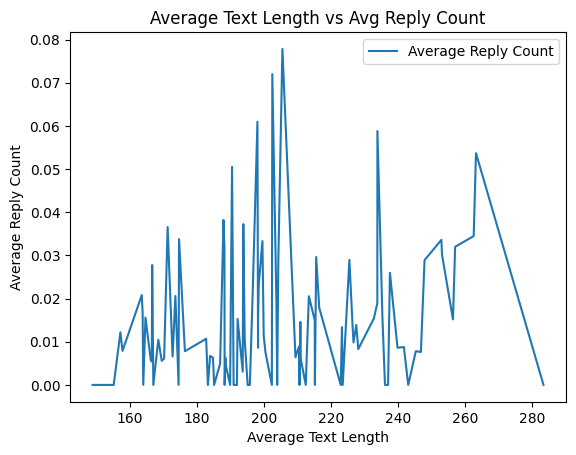

In [10]:
# Plot Interaction Variables
plt.plot(sorted_avg_length['avg_length'], sorted_avg_length['avg_replies'], label='Average Reply Count')

# Adding labels and title
plt.xlabel('Average Text Length')
plt.ylabel('Average Reply Count')
plt.title('Average Text Length vs Avg Reply Count')
plt.legend()

# Show plot
plt.show()

### b. Plot Average Length vs. Number of Reviews

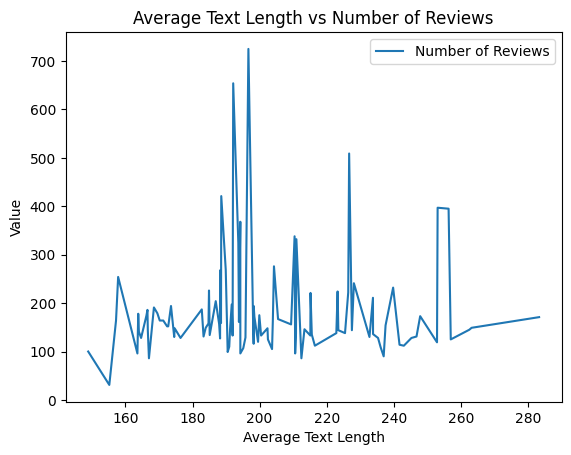

In [11]:
plt.plot(sorted_avg_length['avg_length'], sorted_avg_length['num_reviews'], label='Number of Reviews')

# Adding labels and title
plt.xlabel('Average Text Length')
plt.ylabel('Value')
plt.title('Average Text Length vs Number of Reviews')
plt.legend()

# Show plot
plt.show()

### c. Plot Average Length vs. Average Thumbs Up & Thumbs Down

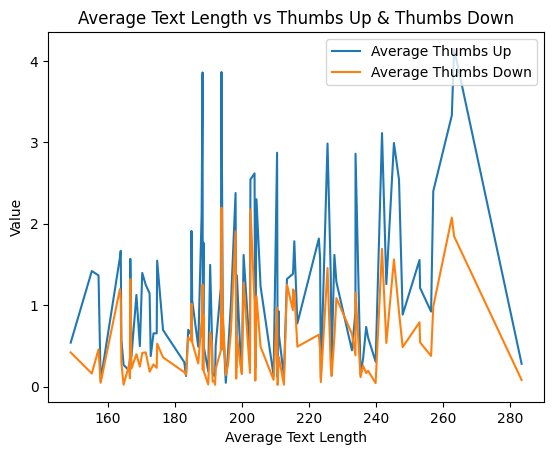

In [12]:
plt.plot(sorted_avg_length['avg_length'], sorted_avg_length['avg_thumbs_up'], label='Average Thumbs Up')
plt.plot(sorted_avg_length['avg_length'], sorted_avg_length['avg_thumbs_down'], label='Average Thumbs Down')

# Adding labels and title
plt.xlabel('Average Text Length')
plt.ylabel('Value')
plt.title('Average Text Length vs Thumbs Up & Thumbs Down')
plt.legend()

# Show plot
plt.show()

### d. Plot Average Length vs. Average Total Interactions

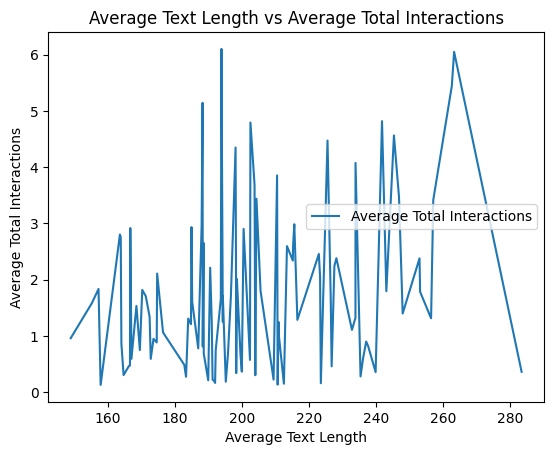

In [13]:
plt.plot(sorted_avg_length['avg_length'], sorted_avg_length['avg_total_interactions'], label='Average Total Interactions')

# Adding labels and title
plt.xlabel('Average Text Length')
plt.ylabel('Average Total Interactions')
plt.title('Average Text Length vs Average Total Interactions')
plt.legend()

# Show plot
plt.show()

### e. Plot Avg Total Interactions vs. Total Reply Count

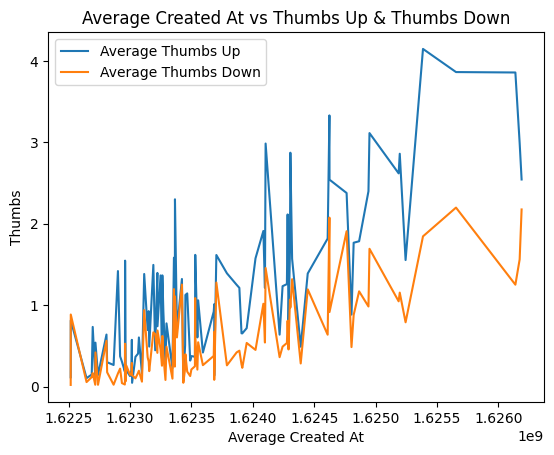

In [14]:
sorted_created_at = avg_length.sort_values(by='avg_created_at')
plt.plot(sorted_created_at['avg_created_at'], sorted_created_at['avg_thumbs_up'], label='Average Thumbs Up')
plt.plot(sorted_created_at['avg_created_at'], sorted_created_at['avg_thumbs_down'], label='Average Thumbs Down')

# Adding labels and title
plt.xlabel('Average Created At')
plt.ylabel('Thumbs')
plt.title('Average Created At vs Thumbs Up & Thumbs Down')
plt.legend()

# Show plot
plt.show()

## Correlation Matrix for Avg Variables

In [15]:
corr_matrix = avg_length.corr()
format_corr_matrix = corr_matrix.style.background_gradient(cmap='coolwarm', axis = None)
new_corr_matrix = format_corr_matrix.format(precision=2)
new_corr_matrix

,recipe_code,avg_length,avg_created_at,num_reviews,avg_replies,avg_thumbs_up,avg_thumbs_down,avg_score,avg_total_interactions
recipe_code,1.00,0.07,0.06,-0.16,-0.15,0.06,0.03,0.12,0.05
avg_length,0.07,1.00,0.31,0.05,0.19,0.27,0.24,0.27,0.27
avg_created_at,0.06,0.31,1.00,0.01,0.51,0.78,0.73,0.86,0.79
num_reviews,-0.16,0.05,0.01,1.00,-0.02,-0.10,-0.12,-0.15,-0.11
avg_replies,-0.15,0.19,0.51,-0.02,1.00,0.55,0.56,0.53,0.58
avg_thumbs_up,0.06,0.27,0.78,-0.10,0.55,1.00,0.87,0.91,0.98
avg_thumbs_down,0.03,0.24,0.73,-0.12,0.56,0.87,1.00,0.79,0.95
avg_score,0.12,0.27,0.86,-0.15,0.53,0.91,0.79,1.00,0.90
avg_total_interactions,0.05,0.27,0.79,-0.11,0.58,0.98,0.95,0.90,1.00


# Question 4 - User Reputation vs. Sentiment
### Does the user reputation indicate anything about it's sentiment?
- Calculate average user reputation of reviews for each recipe.
- Calculate average sentiment for reviews of each recipe. 
- Calculate sentiment of recipe title?

# Part 2: Predicting Review Score using ML
### What features are most important to the review score / order of appearance on recipe comments?
- Models: Linear Regression, Ridge Regression, LASSO, Regression Tree, Bagging, Random Forest, Boosted Trees, Neural Network
- Features (normalize): user_reputation, created_at, reply_count, thumbs_up, thumbs_down, stars, text_length
- Target: best_score

## A. Clean Data
### 1. Remove unnecessary variables

In [16]:
data_ML_raw = data.drop(['Unnamed: 0', 'recipe_number', 'user_id', 'user_name'], axis = 1)
data_ML_raw.head()

,recipe_code,recipe_name,comment_id,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


### 2. Sort data by recipe_code (ascending) & best_score (descending)

In [17]:
# sort dataframe by recipe_code & best_score
data_ML_sorted = data_ML_raw.sort_values(['recipe_code', 'best_score'], ascending = [True, False])
data_ML_sorted.head()

,recipe_code,recipe_name,comment_id,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
7761,386,Hot Milk Cake,sp_aUSaElGf_386_c_1ybGEs91lVCmxcU68a6xDxIgq5t,1,1632512765,0,41,2,0,922,This is very similar to the recipe I grew up w...
7757,386,Hot Milk Cake,sp_aUSaElGf_386_c_2Ddrc8KBpq9jZ2OUZkjPLEz1nBB,1,1661039878,0,10,0,4,851,My husband loves this recipe! The only thing ...
7759,386,Hot Milk Cake,sp_aUSaElGf_386_c_26z31AlGvDdp2FDsBiOYdcaDamn,1,1648412369,0,22,3,5,841,Wonderfully flavored cake. I followed the advi...
7758,386,Hot Milk Cake,sp_aUSaElGf_386_c_28DPJerhU4Tz1Urg7URYCvbomRM,10,1650748112,0,7,0,5,835,"My mom gave this recipe to me years ago, and i..."
7755,386,Hot Milk Cake,sp_aUSaElGf_386_c_2FH8FfVpgwDPx2PQuG5ASe5g9IS,1,1664137547,0,13,0,4,834,My grandmother made this and when it came out ...


### 3. Count character length of "recipe_name" and "text" columns

In [18]:
# create new dataframe for recipe_name length and text length
text_lengths = data_ML_sorted.apply(lambda row: [len(str(row['recipe_name'])), len(str(row['text']))], axis = 1, result_type = 'expand')
text_lengths.columns = ['recipe_name_length', 'review_length']

# append new dataframe to existing data_ML
data_ML = pd.concat([data_ML_sorted, text_lengths], axis = 1, join = 'outer')
data_ML.head()

,recipe_code,recipe_name,comment_id,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text,recipe_name_length,review_length
7761,386,Hot Milk Cake,sp_aUSaElGf_386_c_1ybGEs91lVCmxcU68a6xDxIgq5t,1,1632512765,0,41,2,0,922,This is very similar to the recipe I grew up w...,13,287
7757,386,Hot Milk Cake,sp_aUSaElGf_386_c_2Ddrc8KBpq9jZ2OUZkjPLEz1nBB,1,1661039878,0,10,0,4,851,My husband loves this recipe! The only thing ...,13,134
7759,386,Hot Milk Cake,sp_aUSaElGf_386_c_26z31AlGvDdp2FDsBiOYdcaDamn,1,1648412369,0,22,3,5,841,Wonderfully flavored cake. I followed the advi...,13,191
7758,386,Hot Milk Cake,sp_aUSaElGf_386_c_28DPJerhU4Tz1Urg7URYCvbomRM,10,1650748112,0,7,0,5,835,"My mom gave this recipe to me years ago, and i...",13,205
7755,386,Hot Milk Cake,sp_aUSaElGf_386_c_2FH8FfVpgwDPx2PQuG5ASe5g9IS,1,1664137547,0,13,0,4,834,My grandmother made this and when it came out ...,13,132


### 4. Standardize / Normalize variables

#### a) Visualize each variable's distribution

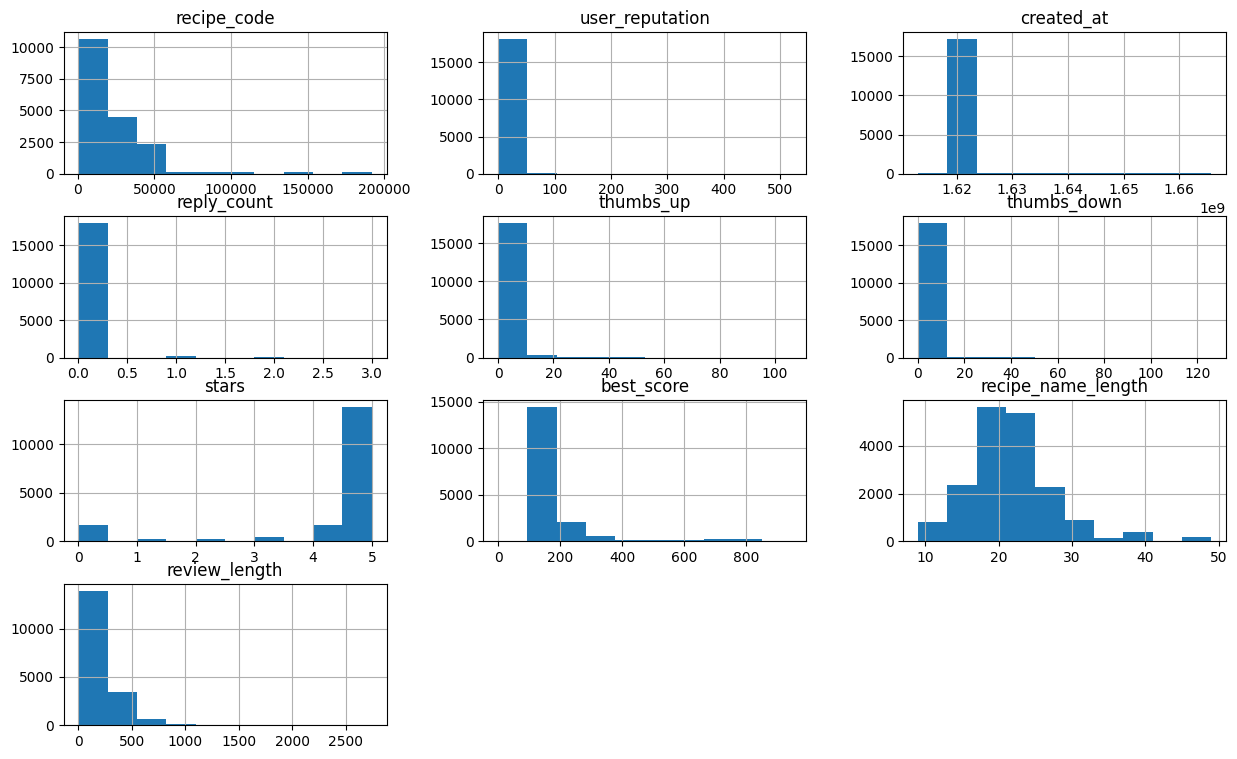

In [19]:
data_ML
data_ML.hist(figsize =(15,9))
plt.show()

#### b) Standardize recipe_name_length & Normalize all others

In [20]:
# identify column to standardize & column to normalize
col_standardize = 'recipe_name_length'
col_normalize = ['user_reputation', 'created_at', 'reply_count', 'thumbs_up', 'thumbs_down', 'stars','best_score', 'review_length']

# initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# transform variables
data_ML[col_standardize] = standard_scaler.fit_transform(data_ML[[col_standardize]])
data_ML[col_normalize] = minmax_scaler.fit_transform(data_ML[col_normalize])

data_ML.head()

,recipe_code,recipe_name,comment_id,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text,recipe_name_length,review_length
7761,386,Hot Milk Cake,sp_aUSaElGf_386_c_1ybGEs91lVCmxcU68a6xDxIgq5t,0.001923,0.369446,0.0,0.386792,0.015873,0.0,0.974630,This is very similar to the recipe I grew up w...,-1.358367,0.104341
7757,386,Hot Milk Cake,sp_aUSaElGf_386_c_2Ddrc8KBpq9jZ2OUZkjPLEz1nBB,0.001923,0.910544,0.0,0.094340,0.000000,0.8,0.899577,My husband loves this recipe! The only thing ...,-1.358367,0.048522
7759,386,Hot Milk Cake,sp_aUSaElGf_386_c_26z31AlGvDdp2FDsBiOYdcaDamn,0.001923,0.671027,0.0,0.207547,0.023810,1.0,0.889006,Wonderfully flavored cake. I followed the advi...,-1.358367,0.069318
7758,386,Hot Milk Cake,sp_aUSaElGf_386_c_28DPJerhU4Tz1Urg7URYCvbomRM,0.019231,0.715331,0.0,0.066038,0.000000,1.0,0.882664,"My mom gave this recipe to me years ago, and i...",-1.358367,0.074425
7755,386,Hot Milk Cake,sp_aUSaElGf_386_c_2FH8FfVpgwDPx2PQuG5ASe5g9IS,0.001923,0.969301,0.0,0.122642,0.000000,0.8,0.881607,My grandmother made this and when it came out ...,-1.358367,0.047793


### 5. Split the data into training and testing

In [21]:
X = data_ML[['user_reputation', 'created_at', 'reply_count', 'thumbs_up', 
           'thumbs_down', 'stars', 'recipe_name_length', 'review_length']]
y = data_ML[ 'best_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

## B. Model Development

### 1. Linear Regression

In [22]:
# initialize Linear Regression object
LR_model = LinearRegression()

# fit the model
LR_model.fit(X_train, y_train)

# predict
LR_predictions = LR_model.predict(X_test)

# get coefficients of model
LR_params = []
for c in LR_model.coef_: LR_params.append("{:.4f}".format(c))

### 2. Ridge Regression

In [23]:
# initialize parameter grid for CV
RR_param_grid = {'alpha': [0.01, 0.1, 1, 10]}

# intialize Ridge Regression object
ridge = Ridge()
RR_grid_search = GridSearchCV(estimator=ridge, param_grid = RR_param_grid, cv = 5)

# fit the model with hyperparmater tuning & find best model
RR_grid_search.fit(X_train, y_train)
RR_best_model = RR_grid_search.best_estimator_

# predict using the best model
RR_predictions = RR_best_model.predict(X_test)

# get coefficients of best model
RR_params = []
for c in RR_best_model.coef_: RR_params.append("{:.4f}".format(c))

### 3. LASSO

In [24]:
# initialize parameter grid for CV
LS_param_grid = {'alpha': [0.01, 0.1, 1, 10]}

# intialize LASSO object
lasso = Lasso()
LS_grid_search = GridSearchCV(estimator=lasso, param_grid = LS_param_grid, cv = 5)

# fit the model with hyperparameter tuning & find best model
LS_grid_search.fit(X_train, y_train)
LS_best_model = LS_grid_search.best_estimator_

# predict using the best model
LS_predictions = LS_best_model.predict(X_test)

# get coefficients of best model
LS_params = []
for c in LS_best_model.coef_: LS_params.append("{:.4f}".format(c))

### 4. Decision Tree

In [25]:
# initialize parameter grid for CV
DT_param_grid = {
    'max_depth': [2, 4, 6],  # None for no limit
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['friedman_mse'] 
}

# initialize Decision Tree object
dt = DecisionTreeRegressor()
DT_grid_search = GridSearchCV(estimator=dt, param_grid=DT_param_grid, cv=5)

# fit the model with hyperparamter tuning & find best model
DT_grid_search.fit(X_train, y_train)
DT_best_model = DT_grid_search.best_estimator_

# predict using the best model
DT_predictions = DT_best_model.predict(X_test)

# get parameters of best model
DT_params = DT_best_model.get_params()

### 5. Random Forest

In [26]:
# intialize parameter grid for CV
RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2,4,6],
}

# initialize RandomForest object
rf = RandomForestRegressor()
RF_grid_search = GridSearchCV(estimator = rf, param_grid = RF_param_grid, cv = 5)

# fit the model with hyperparameter tuning & find best model
RF_grid_search.fit(X_train, y_train)
RF_best_model = RF_grid_search.best_estimator_

# predict using the best model
RF_predictions = RF_best_model.predict(X_test)

# get parameters of best model
RF_params = RF_best_model.get_params()

### 6. Boosted Trees

In [27]:
# initialize parameter grid for CV
BT_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# initialize Boosted Tree object
gbr = GradientBoostingRegressor()
BT_grid_search = GridSearchCV(estimator=gbr, param_grid=BT_param_grid, cv=5)

# fit the model with hyperparameter tuning & find best model
BT_grid_search.fit(X_train, y_train)
BT_best_model = BT_grid_search.best_estimator_

# predict using the best model
BT_predictions = BT_best_model.predict(X_test)

# get parameters of best model
BT_params = BT_best_model.get_params()

## C. Model Features

In [28]:
model_fts = {}
params = [LR_params, RR_params, LS_params, DT_params, RF_params, BT_params]
models = ['Linear Regression', 'Ridge Regression', 'LASSO', 'Decision Tree', 'Random Forest', 'Boosted Trees']

for m, model in enumerate(models):
    model_fts[model] = {'parameters': params[m]}
    
model_features = pd.DataFrame(model_fts).transpose()
pd.set_option('display.max_colwidth', 0)
model_features.style.set_properties(**{'parameters': {'width': 100, 'white-space': 'normal'}})
model_features

,parameters
Linear Regression,"[0.0637, 0.7549, 0.1066, 2.0455, -0.5679, 0.0062, -0.0010, 0.0605]"
Ridge Regression,"[0.0627, 0.7553, 0.1060, 2.0333, -0.5560, 0.0063, -0.0010, 0.0610]"
LASSO,"[0.0000, 0.0455, 0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000]"
Decision Tree,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}"
Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
Boosted Trees,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}"


## D. Model Performance

In [31]:
model_metrics = {}

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)


models = ['Linear Regression', 'Ridge Regression', 'LASSO', 'Decision Tree', 'Random Forest', 'Boosted Trees']
predictions = [LR_predictions, RR_predictions, LS_predictions, DT_predictions, RF_predictions, BT_predictions]

for m, model in enumerate(models):
    mae = mean_absolute_error(y_test, predictions[m])
    mse = mean_squared_error(y_test, predictions[m])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions[m])
    
    model_name = model  # Name for clarity
    model_metrics[model_name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R-Squared': r2}

model_performance = pd.DataFrame(model_metrics)
model_performance

,Linear Regression,Ridge Regression,LASSO,Decision Tree,Random Forest,Boosted Trees
MAE,0.040946,0.041014,0.086708,0.005175,0.004185,0.003836
MSE,0.005389,0.005389,0.021772,0.000519,0.000367,0.000423
RMSE,0.073407,0.073410,0.147555,0.022781,0.019160,0.020578
R-Squared,0.763134,0.763112,0.042940,0.977188,0.983863,0.981387


## E. Feature Magnitude / Importances

In [30]:
# define features in each model & models used
features = ['user_reputation', 'created_at', 'reply_count', 'thumbs_up', 'thumbs_down', 'stars', 'best_score', 'recipe_name_length', 'review_length']
linear_models = ['Linear Regression', 'Ridge Regression', 'LASSO']
tree_models = ['Decision Tree', 'Random Forest', 'Boosted Trees']

# get coefficients & features importances for models
linear_coeff = [LR_model.coef_, RR_best_model.coef_, LS_best_model.coef_]
tree_coeff = [DT_best_model.feature_importances_, RF_best_model.feature_importances_, BT_best_model.feature_importances_]

# initialize coefficient dictionary
model_coeff = {}

for m, model in enumerate(linear_models):
    
    model_coeff[model] = {'user_reputation': linear_coeff[m][0],
                               'created_at': linear_coeff[m][1],
                               'reply_count': linear_coeff[m][2],
                               'thumbs_up': linear_coeff[m][3],
                               'thumbs_down': linear_coeff[m][4],
                               'stars': linear_coeff[m][5],
                               'recipe_name_length': linear_coeff[m][6],
                               'review_length': linear_coeff[m][7],
                              }

for m, model in enumerate(tree_models):
    model_coeff[model] = {'user_reputation': tree_coeff[m][0],
                               'created_at': tree_coeff[m][1],
                               'reply_count': tree_coeff[m][2],
                               'thumbs_up': tree_coeff[m][3],
                               'thumbs_down': tree_coeff[m][4],
                               'stars': tree_coeff[m][5],
                               'recipe_name_length': tree_coeff[m][6],
                               'review_length': tree_coeff[m][7],
                            }
        
model_values = pd.DataFrame(model_coeff)
model_values

,Linear Regression,Ridge Regression,LASSO,Decision Tree,Random Forest,Boosted Trees
user_reputation,0.063692,0.062671,0.000000,0.000196,0.001197,1.988762e-03
created_at,0.754922,0.755303,0.045485,0.749502,0.745156,7.220617e-01
reply_count,0.106618,0.106003,0.000000,0.000000,0.000248,1.086590e-07
thumbs_up,2.045526,2.033349,0.000000,0.220402,0.221481,2.456750e-01
thumbs_down,-0.567916,-0.555953,0.000000,0.023407,0.025608,2.668795e-02
stars,0.006238,0.006306,-0.000000,0.001504,0.001398,1.315316e-03
recipe_name_length,-0.001031,-0.001026,0.000000,0.000000,0.000885,1.006287e-04
review_length,0.060469,0.061004,0.000000,0.004989,0.004027,2.170571e-03
